# Scene detection demo

In [10]:
import formatData
import utils
import subprocess
import gdown
import modelBuilder
import os
import torch
import numpy as np
import pims
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## 1. Getting key-frame indexes

In [28]:
videoPath = "../data/OVSD/Sintel.mp4" # Put the path to your file here
shotThres = 0.1                               # The shot detection threshold. Higher will produce less shot

videoName = os.path.basename(os.path.splitext(videoPath)[0])

if not os.path.exists("{}_shotBounds.csv".format(videoName)):
    nbFrames = formatData.getNbFrames(videoPath)
    fps = utils.getVideoFPS(videoPath)

    #Detecting shots boundaries. This can be a bit long
    shotBounds = formatData.detect_format_shots(videoPath,shotThres,nbFrames,fps)
       
    #Saving shot boundaries
    np.savetxt("{}_shotBounds.csv".format(videoName),shotBounds)
else:
    shotBounds = np.genfromtxt("{}_shotBounds.csv".format(videoName))
    
keyFrameInds = shotBounds.mean(axis=1).astype(int)

## 2. Loading the model

In [29]:

if not os.path.exists("./modelresnet50_biconvScoInitAtt_epoch462"):
    subprocess.call("gdown https://drive.google.com/uc?id=1WaAGxH4YzvNwvVP2Fjm4xtdgHIMRks1S",shell=True)
    
model = modelBuilder.SceneDet(temp_model="resnet50",featModelName="resnet50",cuda=torch.cuda.is_available(),\
                            scoreConvWindSize=7,scoreConvBiLay=True,scoreConvChan=8,scoreConvAtt=True)


params = torch.load("./modelresnet50_biconvScoInitAtt_epoch462",map_location=torch.device('cpu'))

state_dict = {k.replace("module.cnn.","cnn.module.")\
               .replace("scoreConv.weight","scoreConv.layers.weight")\
               .replace("scoreConv.bias","scoreConv.layers.bias")\
               .replace(".module","") : v for k,v in params.items()}

paramToRemove = []
for param in state_dict.keys():
    if param.find("frameAtt") != -1:
        paramToRemove.append(param)
for param in paramToRemove:
    state_dict.pop(param)

model.load_state_dict(state_dict)



IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## 3. Computing the scene change scores

In [30]:
video = pims.Video(videoPath)

if not os.path.exists("res50_res50_biconvScoInitAtt_youtLarg_7_epoch462_{}.csv".format(videoName)):

    N = 10 #The model reads the first N shots at the same time, then the next N shots, etc.
    imgSize = 299


    #This separates the frame indexes into several batches which size is close to N
    split_keyFrameInds = np.array_split(keyFrameInds,len(keyFrameInds)//N+(len(keyFrameInds)%N != 0))

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    preproc = transforms.Compose([transforms.ToPILImage(),transforms.CenterCrop(imgSize),transforms.ToTensor(),normalize])

    allScores = []

    for frameInds in split_keyFrameInds:

        frameSeq = torch.cat(list(map(lambda x:preproc(video[x]).unsqueeze(0),np.array(frameInds))),dim=0).unsqueeze(0)
        scores = model(frameSeq,None).data
        allScores.append(scores.squeeze(0))

    scores = torch.cat(allScores,dim=0)    
    scores = np.concatenate((keyFrameInds[np.newaxis],scores[np.newaxis,:]),axis=1)

    np.savetxt("res50_res50_biconvScoInitAtt_youtLarg_7_epoch462_{}.csv".format(videoName),scores)
else:
    scores = np.genfromtxt("res50_res50_biconvScoInitAtt_youtLarg_7_epoch462_{}.csv".format(videoName))

## 4. Showing the scene changes

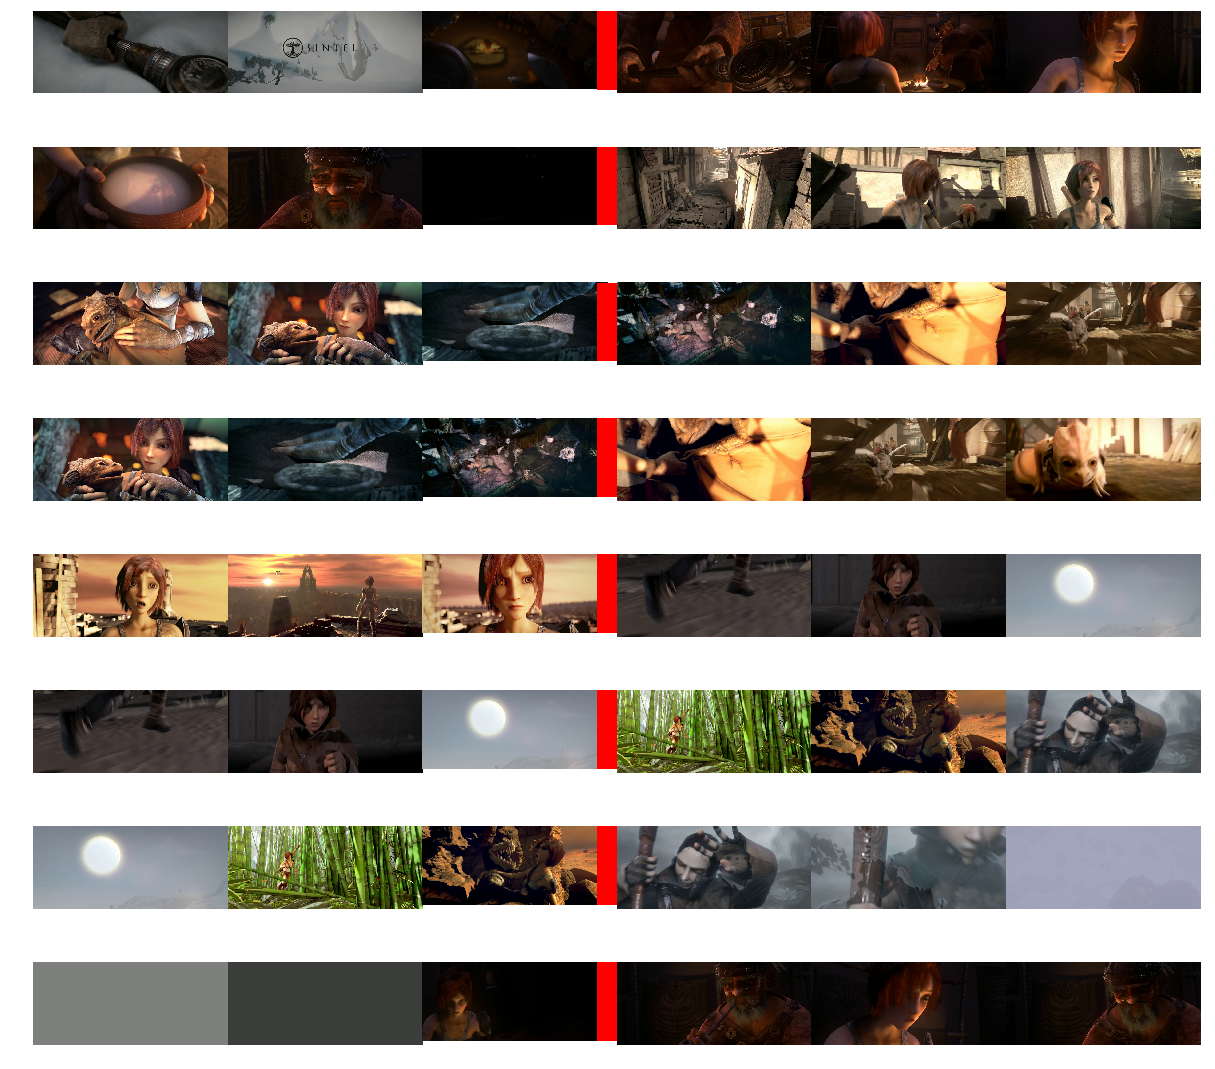

In [40]:
decisionThres = 0.5 # If a shot score is above this threshold, it will be considered as a scene change

#The index of the shots in which a scene change occurs
sceneChange_shotIndex = (scores[:,1]>decisionThres).nonzero()[0]
#The index of the frames in which a scene change occurs
sceneChange_frameIndex = shotBounds[sceneChange_shotIndex][:,0]

imgSize = 20
contextShots = 3
columns = 2*contextShots
rows = 8

frame = video[0]
ratio = frame.shape[1]/frame.shape[0] - 2

plt.figure(figsize=(imgSize*ratio*contextShots, imgSize))

gs1 = gridspec.GridSpec(rows, columns)
gs1.update(wspace=0.0, hspace=0.0)

#Each line shows one scene change (according to the model)
for i in range(rows):

    #Plot some key-frames before the scene change
    for j in range(contextShots):
        precKeyFrameInd = shotBounds[sceneChange_shotIndex[i]+j-contextShots].mean().astype(int)
        plt.subplot(gs1[i*columns+j])
        plt.axis('off')
        plt.imshow(video[precKeyFrameInd])
       
    plt.vlines([video[precKeyFrameInd].shape[1]],0,video[precKeyFrameInd].shape[0],color="red",linewidths=20)
    
    #Plot some key-frames after the scene change
    for j in range(contextShots):
        keyFrameInd = shotBounds[sceneChange_shotIndex[i]+j].mean().astype(int)
        plt.subplot(gs1[i*columns+j+contextShots])
        plt.axis('off')
        plt.imshow(video[keyFrameInd])

plt.show()
plt.savefig("{}_sceneChangeExamples.png")